In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sbn

print(os.listdir("/content/drive/My Drive/Colab Notebooks/kaggle_challenge_dataset"))

In [0]:
#read train and test dataset 
TRAIN_PATH = "/content/drive/My Drive/Colab Notebooks/kaggle_challenge_dataset/train.csv"
TEST_PATH = "/content/drive/My Drive/Colab Notebooks/kaggle_challenge_dataset/test.csv"
SAMPLE_TEST_PATH = "/content/drive/My Drive/Colab Notebooks/kaggle_challenge_dataset/test2.csv"

In [0]:
train_temp = pd.read_csv(TRAIN_PATH, nrows = 500)
print("training dataset head:")
print(train_temp.head())

training dataset head:
                             key  ...  passenger_count
0    2009-06-15 17:26:21.0000001  ...                1
1    2010-01-05 16:52:16.0000002  ...                1
2   2011-08-18 00:35:00.00000049  ...                2
3    2012-04-21 04:30:42.0000001  ...                1
4  2010-03-09 07:51:00.000000135  ...                1

[5 rows x 8 columns]


In [0]:
train_temp.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
key                  500 non-null object
fare_amount          500 non-null float64
pickup_datetime      500 non-null object
pickup_longitude     500 non-null float64
pickup_latitude      500 non-null float64
dropoff_longitude    500 non-null float64
dropoff_latitude     500 non-null float64
passenger_count      500 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 104.0 KB


In [0]:
for dtype in ['float','int','object']:
    selected_dtype = train_temp.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b/ 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 0.00 MB
Average memory usage for int columns: 0.00 MB
Average memory usage for object columns: 0.03 MB


In [0]:
train_temp.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,11.524620,-72.201015,39.773664,-72.347353,39.855403,1.640000
std,9.156087,11.333406,6.243298,10.861792,5.983700,1.281282
min,2.500000,-74.035839,0.000000,-74.035839,0.000000,0.000000
25%,6.000000,-73.992236,40.736283,-73.992803,40.732439,1.000000
50%,8.500000,-73.982112,40.752601,-73.980690,40.753305,1.000000
75%,13.000000,-73.968219,40.766804,-73.964584,40.767905,2.000000
max,58.000000,0.000000,40.828531,0.000000,40.881878,6.000000


Text(0.5, 1.0, 'Histogram of fare amount in USD')

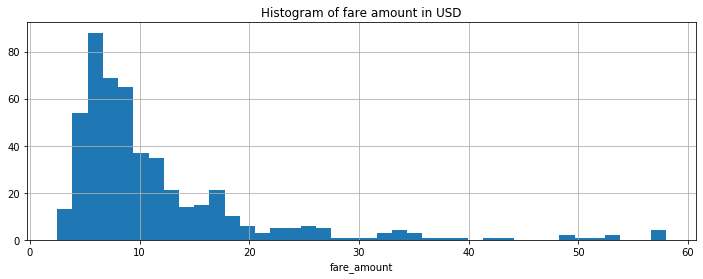

In [0]:
#histogram of fare_amount
train_temp.fare_amount.hist(bins=40, figsize=(12,4))
plt.xlabel('fare_amount')
plt.title('Histogram of fare amount in USD')

In [0]:
test_temp = pd.read_csv(TEST_PATH)
print("test dataset head:")
print(test_temp.head())

test dataset head:
                           key  ... passenger_count
0  2015-01-27 13:08:24.0000002  ...               1
1  2015-01-27 13:08:24.0000003  ...               1
2  2011-10-08 11:53:44.0000002  ...               1
3  2012-12-01 21:12:12.0000002  ...               1
4  2012-12-01 21:12:12.0000003  ...               1

[5 rows x 7 columns]


In [0]:
train_types = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

test_types =  {'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

train_cols = list(train_types.keys())
test_cols = list(test_types.keys())

def clean_df(PATH, cols, datatypes, chunksize):
    if PATH == TEST_PATH:
        df_list = []
        for chunk in pd.read_csv(PATH, usecols = cols, dtype=datatypes, chunksize=chunksize):
            chunk['pickup_datetime'] = chunk['pickup_datetime'].str.slice(0, 16)
            chunk['pickup_datetime'] = pd.to_datetime(chunk['pickup_datetime'], utc=True, 
                                                      format='%Y-%m-%d %H:%M')
            
            #add datetime features to the data 
            #pickup_datetime -> hour, month, year, isWeekday, day
            add_datetime_features(chunk)
            
            #removing data with missing points -> (does not affect the number of sample points)
            #chunk = chunk.dropna(how = 'any', axis = 'rows')
            
            #add distance travelled in km by the cab to dataframe
            chunk['haversine_distnace'] = add_distance(chunk.pickup_latitude, chunk.pickup_longitude,
                        chunk.dropoff_latitude, chunk.dropoff_longitude)

            #add direction of the distance
            chunk['direction'] = calculate_direction(chunk.pickup_latitude, chunk.pickup_longitude,
                        chunk.dropoff_latitude, chunk.dropoff_longitude)
            
            #add a distance_from_JFK_airport to the features as the fare would be more for places closer to airport
            pickup_JFK, dropoff_JFK = add_dist_from_jfk(chunk)
            chunk['JFK_distance'] = pd.concat([pickup_JFK, dropoff_JFK], axis=1).min(axis=1)

            df_list.append(chunk)
            #print(len(df_list))
        return pd.concat(df_list)
    
    elif(PATH == TRAIN_PATH):
        #X_df_list = []
        #y_df_list = []
        df_list = []
        for chunk in pd.read_csv(PATH, usecols = cols, dtype=datatypes, chunksize=chunksize):  
            #converting pickup datetime to proper format
            chunk['pickup_datetime'] = chunk['pickup_datetime'].str.slice(0, 16)
            chunk['pickup_datetime'] = pd.to_datetime(chunk['pickup_datetime'], utc=True, 
                                                      format='%Y-%m-%d %H:%M')
            #outlier removal
            #remove rows with passenger count 0 and more than 6
            chunk = chunk[(chunk['passenger_count'] > 0) & (chunk['passenger_count'] < 7) ]
            
            #remove rows with fare amount less than $1 and greater than $400 
            chunk = chunk[(chunk['fare_amount'] > 1.0) & (chunk['fare_amount'] < 400.0)]     

            # Remove data with invalid coordinates
            # NY Coordinates are around 40 N and 74 W
            # 1 degree is equal to around 69 miles
            # So this range should be fine for our purpose
            chunk = chunk[(chunk['pickup_latitude'] < 42.0) & (chunk['pickup_latitude'] > 39.0)]
            chunk = chunk[(chunk['dropoff_latitude'] < 42.0) & (chunk['dropoff_latitude'] > 39.0)]
            chunk = chunk[(chunk['pickup_longitude'] < -70.0) & (chunk['pickup_longitude'] > -75.0)]
            chunk = chunk[(chunk['dropoff_longitude'] < -70.0) & (chunk['dropoff_longitude'] > -75.0)]       
            
            #add datetime features to the data 
            #pickup_datetime -> hour, month, year, isWeekday, day
            add_datetime_features(chunk)
            
            #removing data with missing points -> (does not affect the number of sample points)
            #chunk = chunk.dropna(how = 'any', axis = 'rows')
            
            #add distance travelled by the cab to dataframe
            chunk['haversine_distnace'] = add_distance(chunk.pickup_latitude, chunk.pickup_longitude,
                        chunk.dropoff_latitude, chunk.dropoff_longitude)

            #add direction of the distance
            chunk['direction'] = calculate_direction(chunk.pickup_latitude, chunk.pickup_longitude,
                        chunk.dropoff_latitude, chunk.dropoff_longitude)            
            
            chunk = chunk[(chunk['haversine_distnace'] > 0.1) & (chunk['haversine_distnace'] < 400)] 
            
            #add a distance_from_JFK_airport to the features as the fare would be more for places closer to airport
            pickup_JFK, dropoff_JFK = add_dist_from_jfk(chunk)
            chunk['JFK_distance'] = pd.concat([pickup_JFK, dropoff_JFK], axis=1).min(axis=1)

            #appending chunks to the dataframe list
            df_list.append(chunk)
            #y_df_list.append(chunk['fare_amount'])
            #chunk.drop(labels = 'fare_amount', axis=1, inplace=True)
            #X_df_list.append(chunk)
            
        df = pd.concat(df_list)
        #X_df = pd.concat(X_df_list)
        #y_df = pd.concat(y_df_list)
        return  df

def add_datetime_features(data_chunk):
    data_chunk['hour'] = data_chunk.pickup_datetime.dt.hour
    data_chunk['day'] = data_chunk.pickup_datetime.dt.day
    data_chunk['month'] = data_chunk.pickup_datetime.dt.month
    data_chunk['weekday'] = data_chunk.pickup_datetime.dt.weekday
    data_chunk['year'] = data_chunk.pickup_datetime.dt.year
    
    return data_chunk
    
def add_distance(lat1, lon1, lat2, lon2):
    p = np.pi/180.0
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...    

def calculate_direction(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = pickup_lon - dropoff_lon
    
    #Compute bearing distance
    a = np.arctan2(np.sin(dlon * np.cos(dropoff_lat)),np.cos(pickup_lat) * np.sin(dropoff_lat) - np.sin(pickup_lat) * np.cos(dropoff_lat) * np.cos(dlon))
    return a

def add_dist_from_jfk(data_chunk):
    JFK_coord = (40.6413, -73.7781)
    pickup_JFK = add_distance(data_chunk['pickup_latitude'], data_chunk['pickup_longitude'], JFK_coord[0], JFK_coord[1]) 
    dropoff_JFK = add_distance(JFK_coord[0], JFK_coord[1], data_chunk['dropoff_latitude'], data_chunk['dropoff_longitude'])
    #data_chunk['JFK_distance'] = pd.concat([pickup_JFK, dropoff_JFK], axis=1).min(axis=1)

    return pickup_JFK, dropoff_JFK

#insample dataset
train_target = clean_df(TRAIN_PATH, train_cols, train_types, chunksize = 500000)
print(train_target.shape)

#out of samples dataset
test_dataset = clean_df(TEST_PATH, test_cols, test_types, chunksize = 2000)
print(test_dataset.shape)

(53086181, 15)
(9914, 14)


In [0]:
train_target.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,haversine_distnace,direction,JFK_distance
count,5.308618e+07,5.308618e+07,5.308618e+07,5.308618e+07,5.308618e+07,5.308618e+07,5.308618e+07,5.308618e+07,5.308618e+07,5.308618e+07,5.308618e+07,5.308618e+07,5.308618e+07,5.308618e+07
mean,8.139472e+00,-4.045278e+01,2.022639e+01,-4.045278e+01,2.022639e+01,1.691975e+00,1.351765e+01,1.571170e+01,6.268899e+00,3.040971e+00,2.011745e+03,2.116440e+00,3.186226e-01,1.247494e+01
std,9.522867e+00,2.544100e+01,1.272050e+01,2.544100e+01,1.272050e+01,1.307224e+00,6.515233e+00,8.685037e+00,3.436881e+00,1.949043e+00,1.866116e+00,2.501405e+00,1.669658e+00,2.160954e+00
min,1.110000e+00,-7.499804e+01,3.900730e+01,-7.499828e+01,3.901156e+01,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.009000e+03,1.000002e-01,-3.141579e+00,2.463167e-03
25%,6.000000e+00,-7.399229e+01,4.073662e+01,-7.399159e+01,4.073563e+01,1.000000e+00,9.000000e+00,8.000000e+00,3.000000e+00,1.000000e+00,2.010000e+03,8.051382e-01,-8.954259e-01,1.255060e+01
50%,8.500000e+00,-7.398213e+01,4.075340e+01,-7.398064e+01,4.075389e+01,1.000000e+00,1.400000e+01,1.600000e+01,6.000000e+00,3.000000e+00,2.012000e+03,1.363405e+00,-1.269417e-01,1.289996e+01
75%,1.250000e+01,-7.396851e+01,4.076756e+01,-7.396560e+01,4.076841e+01,2.000000e+00,1.900000e+01,2.300000e+01,9.000000e+00,5.000000e+00,2.013000e+03,2.464353e+00,2.260262e+00,1.325358e+01
max,3.993300e+02,-7.000039e+01,4.199717e+01,-7.000227e+01,4.199811e+01,6.000000e+00,2.300000e+01,3.100000e+01,1.200000e+01,6.000000e+00,2.015000e+03,2.123138e+02,3.141593e+00,2.044714e+02


In [0]:
test_dataset.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,haversine_distnace,direction,JFK_distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.976181,40.750954,-73.974945,40.751553,1.671273,13.467420,16.194170,6.857979,2.852834,2011.815816,1.931526,0.262677,12.456539
std,0.042799,0.033542,0.039093,0.035436,1.278747,6.868584,8.838482,3.353272,1.994451,1.803347,2.603093,1.825305,2.506123
min,-74.252190,40.573143,-74.263245,40.568974,1.000000,0.000000,1.000000,1.000000,0.000000,2009.000000,0.000000,-3.140778,0.000000
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000,8.000000,9.000000,4.000000,1.000000,2010.000000,0.000000,-0.919139,12.529862
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000,15.000000,16.000000,7.000000,3.000000,2012.000000,1.366828,-0.156816,12.903472
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000,19.000000,25.000000,10.000000,5.000000,2014.000000,2.536426,2.202680,13.262036
max,-72.986534,41.709557,-72.990967,41.696682,6.000000,23.000000,31.000000,12.000000,6.000000,2015.000000,62.140335,3.140382,83.622993


Text(0.5, 1.0, 'Histogram ride distances in miles')

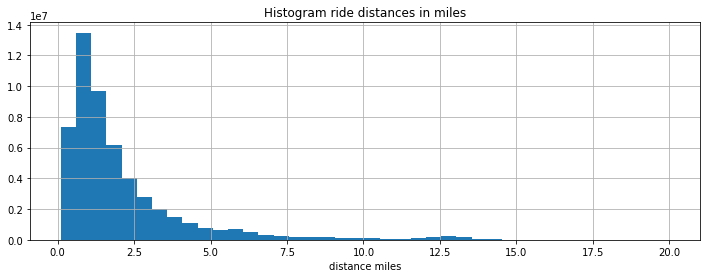

In [0]:
#histogram of haversine distance 
train_target[train_target.haversine_distnace<20].haversine_distnace.hist(bins=40, figsize=(12,4))
plt.xlabel('distance miles')
plt.title('Histogram ride distances in miles')

Text(0.5, 1.0, 'Histogram of fare amount in USD')

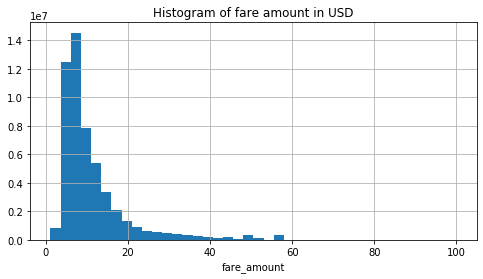

In [0]:
#histogram of fare_amount
train_target[train_target.fare_amount < 100].fare_amount.hist(bins=40, figsize=(8,4))
plt.xlabel('fare_amount')
plt.title('Histogram of fare amount in USD')/content/drive/My Drive/Colab Notebooks/kaggle_challenge_dataset/

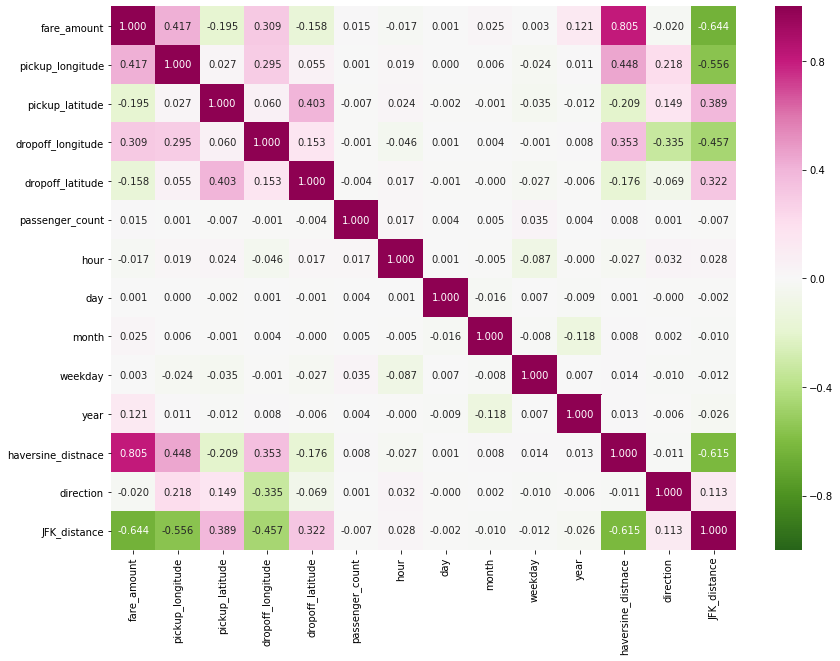

In [0]:
corrs = train_target.corr()
plt.figure(figsize = (14, 10))
sbn.heatmap(corrs, annot = True, vmin = -1, vmax = 1, fmt = '.3f', cmap=plt.cm.PiYG_r);


Text(0, 0.5, 'fare in USD')

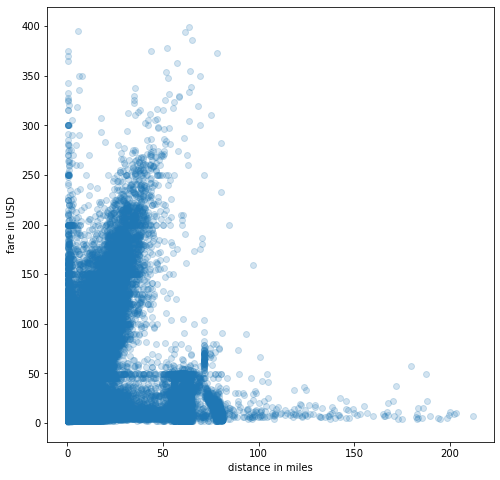

In [0]:
plt.figure(figsize = (8, 8))
plt.scatter(train_target.haversine_distnace, train_target.fare_amount, alpha=0.2)
plt.xlabel('distance in miles')
plt.ylabel('fare in USD')

Text(0, 0.5, 'fare in USD')

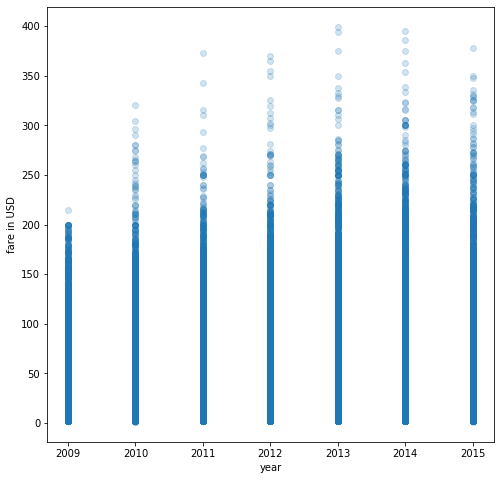

In [0]:
plt.figure(figsize = (8, 8))
plt.scatter(train_target.year, train_target.fare_amount, alpha=0.2)
plt.xlabel('year')
plt.ylabel('fare in USD')

In [0]:
#drop location features as the distance has already been calculated and added to the dataset
features_to_drop = ['pickup_longitude',	'pickup_latitude', 'dropoff_longitude',	'dropoff_latitude', 'day', 'weekday', 'pickup_datetime']
train_target.drop(labels = features_to_drop, axis=1, inplace=True)
print(train_target.shape)

#memory before changing datatypes
train_target.info(memory_usage='deep')

(53086181, 8)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53086181 entries, 0 to 55423855
Data columns (total 8 columns):
fare_amount           float32
passenger_count       uint8
hour                  int64
month                 int64
year                  int64
haversine_distnace    float64
direction             float32
JFK_distance          float64
dtypes: float32(2), float64(2), int64(3), uint8(1)
memory usage: 2.8 GB


In [0]:
#changing datatypes
train_target.month = train_target.month.astype(dtype = 'uint8')
train_target.year = train_target.year.astype(dtype = 'uint16')
train_target.hour = train_target.hour.astype(dtype = 'uint8')
train_target.haversine_distnace = train_target.haversine_distnace.astype(dtype = 'float32')
train_target.JFK_distance = train_target.JFK_distance.astype(dtype = 'float32')

#memory before changing datatypes
train_target.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53086181 entries, 0 to 55423855
Data columns (total 8 columns):
fare_amount           float32
passenger_count       uint8
hour                  uint8
month                 uint8
year                  uint16
haversine_distnace    float32
direction             float32
JFK_distance          float32
dtypes: float32(4), uint16(1), uint8(3)
memory usage: 1.4 GB


In [0]:
train_target.to_csv('/content/drive/My Drive/Colab Notebooks/kaggle_challenge_dataset/dataset.csv', index=False)

In [0]:
train_target.describe()

,fare_amount,passenger_count,hour,month,year,haversine_distnace,direction,JFK_distance
count,5.308618e+07,5.308618e+07,5.308618e+07,5.308618e+07,5.308618e+07,5.308618e+07,5.308618e+07,5.308618e+07
mean,8.139472e+00,1.691975e+00,1.351765e+01,6.268899e+00,2.011745e+03,1.603831e+00,3.186226e-01,5.078047e+00
std,9.522867e+00,1.307224e+00,6.515233e+00,3.436881e+00,1.866116e+00,2.426973e+00,1.669658e+00,6.370333e+00
min,1.110000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.009000e+03,1.000002e-01,-3.141579e+00,2.463167e-03
25%,6.000000e+00,1.000000e+00,9.000000e+00,3.000000e+00,2.010000e+03,8.051382e-01,-8.954259e-01,1.255060e+01
50%,8.500000e+00,1.000000e+00,1.400000e+01,6.000000e+00,2.012000e+03,1.363405e+00,-1.269417e-01,1.289996e+01
75%,1.250000e+01,2.000000e+00,1.900000e+01,9.000000e+00,2.013000e+03,2.464353e+00,2.260262e+00,1.325358e+01
max,3.993300e+02,6.000000e+00,2.300000e+01,1.200000e+01,2.015000e+03,2.123138e+02,3.141593e+00,2.044714e+02


In [0]:
#drop location features as the distance has already been calculated and added to the test dataset
#features_to_drop = ['pickup_longitude',	'pickup_latitude', 'dropoff_longitude',	'dropoff_latitude', 'day', 'weekday', 'pickup_datetime']
test_dataset.drop(labels = features_to_drop, axis=1, inplace=True)
print(test_dataset.shape)

#memory before changing datatypes
test_dataset.info(memory_usage='deep')

In [0]:
#changing datatypes
test_dataset.month = test_dataset.month.astype(dtype = 'uint8')
test_dataset.year = test_dataset.year.astype(dtype = 'uint16')
test_dataset.hour = test_dataset.hour.astype(dtype = 'uint8')
test_dataset.haversine_distnace = test_dataset.haversine_distnace.astype(dtype = 'float64')
test_dataset.JFK_distance = test_dataset.JFK_distance.astype(dtype = 'float64')
#memory before changing datatypes
test_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
passenger_count       9914 non-null uint8
hour                  9914 non-null uint8
month                 9914 non-null uint8
year                  9914 non-null uint16
haversine_distnace    9914 non-null float64
direction             9914 non-null float32
JFK_distance          9914 non-null float64
dtypes: float32(1), float64(2), uint16(1), uint8(3)
memory usage: 242.2 KB


In [0]:
test_dataset.to_csv('/content/drive/My Drive/Colab Notebooks/kaggle_challenge_dataset/test_dataset.csv', index=False)